## Loading Imports

In [1]:
from dl.simple_cnn import SimpleCNN
from dl.shuffle_net import ShuffleNetV2
from dl.mobile_net import MobileNET
from dl.wide_resnet import WideResNet
from dl.capsule_net import CapsuleNet
from dl.callbacks.plot_loss import PlotLosses
from data.data_set import get_data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, TerminateOnNaN, EarlyStopping, ModelCheckpoint, TensorBoard
from config import DL_MODELS_PATH, TB_LOGS_PATH
import os
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from swa.tfkeras import SWA
from dl.callbacks.cyclical_lr import CyclicLR
from plotly.offline import init_notebook_mode
from visualization.visualize_history import plot_accuracy_and_loss

init_notebook_mode(connected=True)

2019-12-19 22:30:06,759 : INFO : Checking/creating directories...
2019-12-19 22:30:06,760 : INFO : Directories are set.


## Loading Data Set

In [2]:
((X_train, y_train), (X_val, y_val)) = get_data()
len(X_train), len(X_val)

(60000, 10000)

## Adding Augmentations

In [ ]:
data_generator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range= .8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = .1, # Randomly zoom image 
        width_shift_range= .1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range= .1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=.05,  # randomly flip images horizontally
        vertical_flip=False)  # randomly flip images vertically

## Generating Callbacks

In [ ]:
def get_callbacks(model_name, use_cyclic_lr=False, plot=False):
    # Terminate when math errors occur
    callbacks = [TerminateOnNaN(), EarlyStopping(monitor='val_accuracy', patience=5)]
    # Save checkpoint in every epoch
    callbacks.append(ModelCheckpoint(os.path.join(DL_MODELS_PATH, model_name + '-{epoch:02d}-{val_accuracy:.2f}.hdf5'), monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max'))
    # Use tensorboard as metrics
    tb_path = os.path.join(TB_LOGS_PATH, model_name)
    pathlib.Path(tb_path).mkdir(parents=True, exist_ok=True)
    callbacks.append(TensorBoard(log_dir=tb_path))
    # https://arxiv.org/abs/1803.05407
    callbacks.append(SWA(start_epoch=5, lr_schedule='constant', swa_lr=0.001, verbose=1))
    if plot:
        callbacks.append(PlotLosses()) # Plots metrics inside Jupyter
    if use_cyclic_lr:
        # https://arxiv.org/abs/1506.01186
        callbacks.append(CyclicLR(base_lr=0.001, max_lr=0.006, step_size=2000.))
    else:
        # Progressively reduce learning rate when speed of converging decreases. 
        rlronp =  ReduceLROnPlateau(monitor='val_loss',
                                    patience=3,
                                    verbose=1,
                                    factor=0.5,
                                    min_lr=0.00005)
        
        callbacks.append(rlronp)
    return callbacks

### Setting Hyperparameters and starting training multiple candidates

In [ ]:
epochs = 50
Learning_rate = 0.001
decay = 5 * Learning_rate / epochs
optimizers = {'adam': Adam(lr=Learning_rate, decay= 3 * Learning_rate / epochs),
              'rmsprop': RMSprop(lr=Learning_rate, rho=0.9, epsilon=1e-08, decay= 0)}

In [ ]:
epochs = 50
histories = {}
models = {}

for opt_name, opt in optimizers.items():
    # Train a basic cnn
    model_name = f'simple_cnn_{opt_name}'
    model = SimpleCNN(opt)
    history = model.train(data_generator, X_train, y_train, X_val, y_val,
                            2048, epochs, get_callbacks(model_name))
    histories[model_name] = history.history
    models[model_name] = model

    # Train shufflenetv2
    model_name = f'shuffle_netv2_cylic_lr_{opt_name}'
    model = ShuffleNetV2(opt)
    history = model.train(data_generator, X_train, y_train, X_val, y_val,
                              256, epochs, get_callbacks(model_name, use_cyclic_lr=True))
    histories[model_name] = history.history
    models[model_name] = model
    
    # Train wide resnet net
    model_name = f'wide_resnet_{opt_name}'
    model = WideResNet(opt)
    history = model.train(data_generator, X_train, y_train, X_val, y_val,
                              32, epochs, get_callbacks(model_name))
    histories[model_name] = history.history
    models[model_name] = model

    # Train mobile_net
    model_name = f'mobile_net_{opt_name}'
    model = MobileNET(opt)
    history = model.train(data_generator, X_train, y_train, X_val, y_val,
                            16, epochs, get_callbacks(model_name))
    histories[model_name] = history.history
    models[model_name] = model
    
    # Train capsule net
    model_name = f'capsnet_{opt_name}'
    model = CapsuleNet(opt)
    history = model.train(data_generator, X_train, y_train, X_val, y_val,
                          16, epochs, get_callbacks(model_name))
    histories[model_name] = history.history
    models[model_name] = model

## Plotting results
`plot_accuracy_and_loss` function can be used without giving histories as a parameter to get the metrics from TensorBoard logs.

In [ ]:
plot_accuracy_and_loss(histories)

## Plotting confussion matrices for some of the best models

2019-12-19 22:30:15,640 : WARNING : Tensor._shape is private, use Tensor.shape instead. Tensor._shape will eventually be removed.


2019-12-19 22:30:15,788 : WARNING : Tensor._shape is private, use Tensor.shape instead. Tensor._shape will eventually be removed.
2019-12-19 22:30:20,528 : INFO : Loaded /home/cenk/Research/pre-trained-models/cv/fashion_mnist/capsnet_adam-24-0.95.hdf5
Resizing training images: 10000it [00:00, 10162.47it/s]


Confusion Matrix


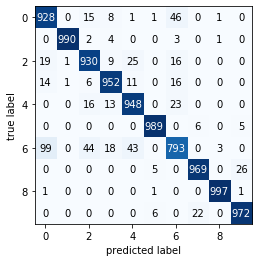

,top,trouser,pullover,dress,coat,sandal,shirt,sneaker,bag,ankle boot,accuracy,macro avg,weighted avg
precision,0.874647,0.997984,0.918065,0.948207,0.922179,0.987026,0.884058,0.971916,0.995010,0.968127,0.9468,0.946722,0.946722
recall,0.928000,0.990000,0.930000,0.952000,0.948000,0.989000,0.793000,0.969000,0.997000,0.972000,0.9468,0.946800,0.946800
f1-score,0.900534,0.993976,0.923994,0.950100,0.934911,0.988012,0.836057,0.970456,0.996004,0.970060,0.9468,0.946410,0.946410
support,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,0.9468,10000.000000,10000.000000


In [3]:
model = WideResNet(Adam())
model.load_from_best_checkpoint('capsnet_adam')
model.evaluate(X_val, y_val, plot_confussion=True)